# <span style='color:#0D2BA5'>Projet 8 -  Test Veille technoligique (nouveau modele) en Comparaison avec ceux du Projet 6 pour le Traitement de Texte</span>

## <span style='background:#33B5FF'>Table des Matieres</span>

In [ ]:
#!pip install jyquickhelper
#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

## <span style='background:#33B5FF'>1. Introduction</span>

## <span style='background:#33B5FF'>2. Bibliothèques d'analyse Python</span>

In [2]:
# Chargement des librairies
import datetime
import time
import sys
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import doc2vec

# Plotly Libraries
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib as mpl
import matplotlib.pyplot as plt
# Feature extraction
import seaborn as sns
# BERT
import transformers
#!pip install sentence_transformers
#from sentence_transformers import SentenceTransformer
# USE
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
# Clustering
from IPython.display import display, Markdown
import gensim
#!pip install git+https://github.com/pycaret/pycaret.git#egg=pycaret
from pycaret.classification import *

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

%matplotlib inline

In [3]:
# Qualité Clusters
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score

In [4]:
def affiche_repartition_clusters(clusters_labels):
    '''
    Affiche la répartition par cluster
    Parameters
    ----------
    clusters_labels : la séries des labels des clusters, obligatoire.
    Returns
    -------
    None.
    '''
    ax1 = plt.gca()

    # DataFrame de travail
    series_client_cluster = pd.Series(clusters_labels).value_counts()
    nb_client = series_client_cluster.sum()
    df_visu_client_cluster = pd.DataFrame(
        {'Clusters': series_client_cluster.index,
         'Nombre': series_client_cluster.values})
    df_visu_client_cluster['%'] = round(
        (df_visu_client_cluster['Nombre']) * 100 / nb_client, 2)
    df_visu_client_cluster = df_visu_client_cluster.sort_values(by='Clusters')
    display(df_visu_client_cluster.style.hide_index())

    # Barplot de la distribution
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nombre',
                data=df_visu_client_cluster, color='SteelBlue', ax=ax1)
    ax1.set_ylabel('Nombre)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Répartition par clusters', fontsize=14)
    ax1.tick_params(axis='x', labelrotation=90)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()


In [5]:
def affiche_qualite_classification(dataframe, titre):
    '''
    Afiche heatmap de la qualité de la catégorisation et donne l'accuracy.
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    titre : type de données traitées.
    Returns
    -------
    None.
    '''
    cat_pred = dataframe['prediction_label']
    cat_reel = dataframe['CATEGORIE']

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(cat_reel, cat_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='Blues',
                yticklabels=sorted(cat_pred.unique()))
    plt.title(titre)
    plt.show()

    display(
        'Précision: {}%'.format(
            round(
                accuracy_score(
                    cat_pred,
                    cat_reel) *
                100,
                2)))
    display(Markdown(classification_report(cat_reel, cat_pred)))


In [6]:
def classifier_pycaret(data_cat, vector, titre):

    # Réduction de dimension
    tsne = TSNE(verbose=1, perplexity=50, n_iter=5000)
    X_proj_tsne = tsne.fit_transform(vector)
    # Dataframe pour clustering
    df_class = pd.DataFrame({'VAR1': X_proj_tsne[:, 0],
                             'VAR2': X_proj_tsne[:, 1],
                             'CATEGORIE': data_cat})

    # Classification PyCaret
    # Initialisation
    # Initialisation de l'environnement d'expérimentation

    # Comparez les performances des différents modèles

    setup(df_class,
          target='CATEGORIE',
          session_id=21,
          experiment_name=titre,
          verbose = True)
    remove_metric('AUC')
    compare_models()

    # Lancement de pycaret
    best_model = compare_models()

    # Prédictions
    df_result = predict_model(best_model)

    # Labels
    labels = df_result['prediction_label']

    # Répartition des clusters
    affiche_repartition_clusters(labels)

    # Heatmap de matrice de confusion
    affiche_qualite_classification(df_result, titre)

## <span style='background:#33B5FF'>3. chargement des données</span>

In [7]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Chargement du jeu de données
data = pd.read_csv('/content/drive/MyDrive/Test_VT/data_clean.csv')
# Supprime varaible Unnamed: 0
data.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
data_cat = data['Categorie_1']

In [12]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 9 variables.


In [ ]:
# 2 premières lignes
data.head(2)

,product_name,brand,image,product_category_tree,description,product_specifications,Categorie_1,description_clean,description_token
0,Elegance Polyester Multicolor Abstract Eyelet ...,Elegance,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing >> Curtains & Accessories >> C...,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,abstract eyelet door curtain floral curtain ab...,"['abstract', 'eyelet', 'door', 'curtain', 'flo..."
1,Sathiyas Cotton Bath Towel,Sathiyas,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,bath towel bath towel red yellow bath towel ma...,"['bath', 'towel', 'bath', 'towel', 'red', 'yel..."


## <span style='background:#33B5FF'>4. Texte + Classification Supervisée avec anciens Modeles</span>

### <span style=''>4.1 BERT avec Classification supervisée</span>

In [11]:
cols = ['VAR1', 'VAR2']

In [12]:
data['description_clean'] = \
    data['description_clean'].fillna('').astype(str)
data_desc = data['description_clean']

In [13]:
# Prendre un échantillon aléatoire de données (T5)
data_sample = data_desc.sample(n=100, random_state=21)
data_cat_sample = data_cat.loc[data_sample.index]

In [17]:
# Instanciation du modèle
bert_desc_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_orig = bert_desc_orig.encode(data_desc)

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
titre = 'TSNE_ROBERTA_DESC'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.217278
[t-SNE] KL divergence after 2300 iterations: 0.805217


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7375,0.7375,0.7409,0.7339,0.6936,0.6953,0.1830
rf,Random Forest Classifier,0.7198,0.7198,0.7302,0.7167,0.6729,0.6754,0.2340
lightgbm,Light Gradient Boosting Machine,0.6980,0.6980,0.7055,0.6952,0.6475,0.6496,1.1210
knn,K Neighbors Classifier,0.6775,0.6775,0.6923,0.6752,0.6237,0.6266,0.0750
xgboost,Extreme Gradient Boosting,0.6749,0.6749,0.6870,0.6705,0.6205,0.6231,0.2420
dt,Decision Tree Classifier,0.6680,0.6680,0.6774,0.6629,0.6125,0.6155,0.0580
gbc,Gradient Boosting Classifier,0.6477,0.6477,0.6557,0.6448,0.5888,0.5909,1.0830
qda,Quadratic Discriminant Analysis,0.4012,0.4012,0.4033,0.3675,0.3016,0.3109,0.0360
nb,Naive Bayes,0.3876,0.3876,0.3784,0.3574,0.2856,0.2922,0.0520
ada,Ada Boost Classifier,0.3511,0.3511,0.3574,0.3368,0.2434,0.2476,0.1280


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7375,0.7375,0.7409,0.7339,0.6936,0.6953,0.1860
rf,Random Forest Classifier,0.7198,0.7198,0.7302,0.7167,0.6729,0.6754,0.2350
lightgbm,Light Gradient Boosting Machine,0.6980,0.6980,0.7055,0.6952,0.6475,0.6496,1.5700
knn,K Neighbors Classifier,0.6775,0.6775,0.6923,0.6752,0.6237,0.6266,0.0700
xgboost,Extreme Gradient Boosting,0.6749,0.6749,0.6870,0.6705,0.6205,0.6231,0.2710
dt,Decision Tree Classifier,0.6680,0.6680,0.6774,0.6629,0.6125,0.6155,0.0370
gbc,Gradient Boosting Classifier,0.6477,0.6477,0.6557,0.6448,0.5888,0.5909,1.1080
qda,Quadratic Discriminant Analysis,0.4012,0.4012,0.4033,0.3675,0.3016,0.3109,0.0350
nb,Naive Bayes,0.3876,0.3876,0.3784,0.3574,0.2856,0.2922,0.0510
ada,Ada Boost Classifier,0.3511,0.3511,0.3574,0.3368,0.2434,0.2476,0.1250


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7238,0.7238,0.7253,0.7215,0.6778,0.6787


Clusters,Nombre,%
Baby Care,38,12.060000
Beauty and Personal Care,46,14.600000
Computers,48,15.240000
Home Decor & Festive Needs,46,14.600000
Home Furnishing,54,17.140000
Kitchen & Dining,47,14.920000
Watches,36,11.430000


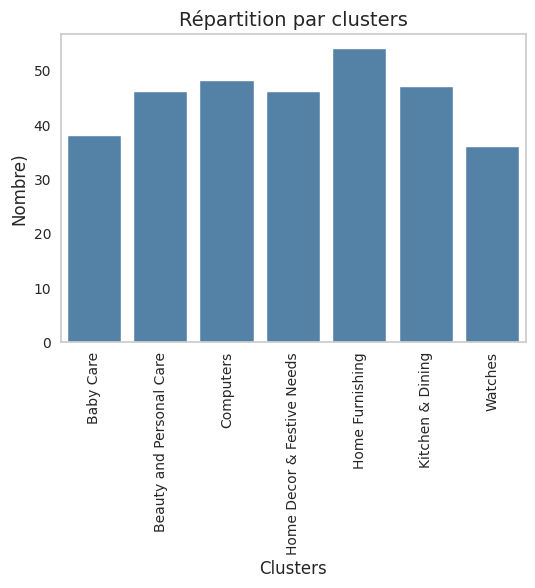

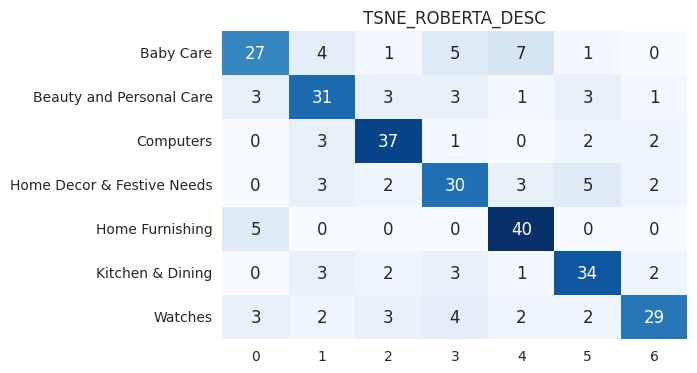

'Précision: 72.38%'

                            precision    recall  f1-score   support

                 Baby Care       0.71      0.60      0.65        45
  Beauty and Personal Care       0.67      0.69      0.68        45
                 Computers       0.77      0.82      0.80        45
Home Decor & Festive Needs       0.65      0.67      0.66        45
           Home Furnishing       0.74      0.89      0.81        45
          Kitchen & Dining       0.72      0.76      0.74        45
                   Watches       0.81      0.64      0.72        45

                  accuracy                           0.72       315
                 macro avg       0.73      0.72      0.72       315
              weighted avg       0.73      0.72      0.72       315


In [19]:
classifier_pycaret(data_cat, vector_roberta_desc_orig, titre)

In [20]:
def sauvegarder_accuracy_pycaret(dataframe, score_train, score_test, titre):
    '''

    Parameters
    ----------
    dataframe : TYPE
        DESCRIPTION.
    score_train : TYPE
        DESCRIPTION.
    score_test : TYPE
        DESCRIPTION.
    titre : TYPE
        DESCRIPTION.

    Returns
    -------
    dataframe_metrics : TYPE
        DESCRIPTION.
    '''
    dataframe_metrics = dataframe._append(pd.DataFrame({
        'Type_données': [titre],
        'Accuracy_train': [score_train],
        'Accuracy_test': [score_test]
    }), ignore_index=True)

    dataframe_metrics.to_csv('/content/drive/MyDrive/Test_VT/data_accuracy_classification.csv')

    return dataframe_metrics

In [21]:
df_accuracy_class = pd.DataFrame({})

In [22]:
# Sauvegarde des résultats
df_accuracy_class =sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7375', '0.7238', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
0,TSNE_ROBERTA_DESC,0.7375,0.7238


### <span style=''>4.2 USE avec Classification supervisée</span>

In [23]:
use_module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [24]:
# Chargement du modèle
use_model_prod_orig = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [25]:
vector_use_desc = use_model_prod_orig(data_desc)

In [26]:
titre = 'TSNE_USE_DESC'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.204170
[t-SNE] KL divergence after 5000 iterations: 1.007188


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7607,0.7607,0.7744,0.7604,0.7208,0.7228,0.2720
rf,Random Forest Classifier,0.7457,0.7457,0.7616,0.7456,0.7032,0.7057,0.2270
xgboost,Extreme Gradient Boosting,0.7144,0.7144,0.7268,0.7121,0.6667,0.6693,0.2220
knn,K Neighbors Classifier,0.7117,0.7117,0.7322,0.7097,0.6636,0.6671,0.0420
lightgbm,Light Gradient Boosting Machine,0.7103,0.7103,0.7198,0.7083,0.6619,0.6641,0.7700
gbc,Gradient Boosting Classifier,0.6804,0.6804,0.6959,0.6774,0.6271,0.6304,1.0560
dt,Decision Tree Classifier,0.6790,0.6790,0.6953,0.6791,0.6253,0.6278,0.0350
qda,Quadratic Discriminant Analysis,0.3239,0.3239,0.3227,0.2923,0.2113,0.2190,0.0460
nb,Naive Bayes,0.3171,0.3171,0.2936,0.2797,0.2035,0.2119,0.0330
lr,Logistic Regression,0.2940,0.2940,0.2608,0.2516,0.1762,0.1830,0.0450


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7607,0.7607,0.7744,0.7604,0.7208,0.7228,0.2740
rf,Random Forest Classifier,0.7457,0.7457,0.7616,0.7456,0.7032,0.7057,0.2310
xgboost,Extreme Gradient Boosting,0.7144,0.7144,0.7268,0.7121,0.6667,0.6693,0.3170
knn,K Neighbors Classifier,0.7117,0.7117,0.7322,0.7097,0.6636,0.6671,0.0450
lightgbm,Light Gradient Boosting Machine,0.7103,0.7103,0.7198,0.7083,0.6619,0.6641,1.4460
gbc,Gradient Boosting Classifier,0.6804,0.6804,0.6959,0.6774,0.6271,0.6304,0.9620
dt,Decision Tree Classifier,0.6790,0.6790,0.6953,0.6791,0.6253,0.6278,0.0350
qda,Quadratic Discriminant Analysis,0.3239,0.3239,0.3227,0.2923,0.2113,0.2190,0.0320
nb,Naive Bayes,0.3171,0.3171,0.2936,0.2797,0.2035,0.2119,0.0340
lr,Logistic Regression,0.2940,0.2940,0.2608,0.2516,0.1762,0.1830,0.0450


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7524,0.7524,0.7494,0.7493,0.7111,0.7116


Clusters,Nombre,%
Baby Care,41,13.020000
Beauty and Personal Care,42,13.330000
Computers,49,15.560000
Home Decor & Festive Needs,40,12.700000
Home Furnishing,49,15.560000
Kitchen & Dining,43,13.650000
Watches,51,16.190000


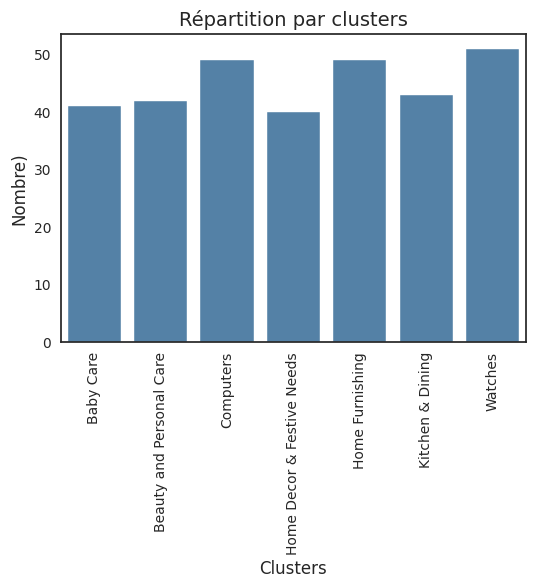

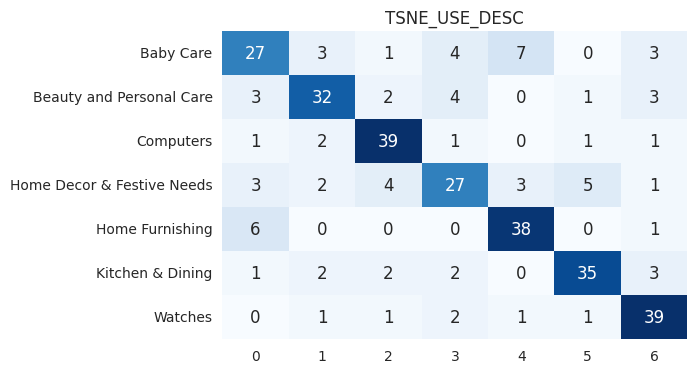

'Précision: 75.24%'

                            precision    recall  f1-score   support

                 Baby Care       0.66      0.60      0.63        45
  Beauty and Personal Care       0.76      0.71      0.74        45
                 Computers       0.80      0.87      0.83        45
Home Decor & Festive Needs       0.68      0.60      0.64        45
           Home Furnishing       0.78      0.84      0.81        45
          Kitchen & Dining       0.81      0.78      0.80        45
                   Watches       0.76      0.87      0.81        45

                  accuracy                           0.75       315
                 macro avg       0.75      0.75      0.75       315
              weighted avg       0.75      0.75      0.75       315


In [27]:
classifier_pycaret(data_cat, vector_use_desc, titre)

In [ ]:
#!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
#!pip install pycaret[models]

In [28]:
# Sauvegarde des résultats
df_accuracy_class =sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7607', '0.7524', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]


,Type_données,Accuracy_train,Accuracy_test
1,TSNE_USE_DESC,0.7607,0.7524


## <span style='background:#33B5FF'>5. Texte + Classification Supervisée avec Le modele Récent : T5 "Text-To-Text Transfer Transformer </span>

In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [ ]:
#!pip install --user -U scikit-learn==0.23.2

In [2]:
model_name = "t5-small"  # Utilisation du modèle T5-small
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [1]:
# Génération des embeddings pour les descriptions
inputs = tokenizer(list(data_sample.values), return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = model(input_ids=inputs["input_ids"], decoder_input_ids=inputs["input_ids"])
# Obtenir les embeddings à partir des logits de la séquence générée
logits = outputs.logits
embeddings = logits[:, 0, :].detach().cpu().numpy()

In [32]:
# Réduction de dimension avec t-SNE
tsne = TSNE(verbose=1, perplexity=50, n_iter=5000)
X_proj_tsne = tsne.fit_transform(embeddings)

# Dataframe pour clustering
df_class = pd.DataFrame({'VAR1': X_proj_tsne[:, 0],
                         'VAR2': X_proj_tsne[:, 1],
                         'CATEGORIE': data_cat_sample})

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.006s...
[t-SNE] Computed neighbors for 100 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 640.029213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.004944
[t-SNE] KL divergence after 700 iterations: 0.010453


In [33]:
titre = 'TSNE_T5'

In [34]:
# Classification PyCaret
setup(df_class,
      target='CATEGORIE',
      session_id=21,
      experiment_name=titre,
      verbose=True)
remove_metric('AUC')
compare_models()
# Lancement de pycaret
best_model = compare_models()

# Prédictions
df_result = predict_model(best_model)

,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(100, 3)"
5,Transformed data shape,"(100, 3)"
6,Transformed train set shape,"(70, 3)"
7,Transformed test set shape,"(30, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3857,0.3857,0.2619,0.3024,0.2803,0.2987,0.0400
lda,Linear Discriminant Analysis,0.3429,0.3429,0.2214,0.2595,0.2301,0.2457,0.0320
rf,Random Forest Classifier,0.3000,0.3000,0.2333,0.2500,0.1857,0.1985,0.1760
et,Extra Trees Classifier,0.3000,0.3000,0.2405,0.2595,0.1844,0.1937,0.1470
qda,Quadratic Discriminant Analysis,0.2857,0.2857,0.1667,0.2038,0.1631,0.1769,0.0330
nb,Naive Bayes,0.2714,0.2714,0.1619,0.1952,0.1491,0.1640,0.0550
ridge,Ridge Classifier,0.2714,0.2714,0.1405,0.1800,0.1528,0.1717,0.0320
dt,Decision Tree Classifier,0.2571,0.2571,0.1976,0.2167,0.1273,0.1376,0.0600
knn,K Neighbors Classifier,0.2429,0.2429,0.1940,0.2033,0.1243,0.1384,0.0660
gbc,Gradient Boosting Classifier,0.2286,0.2286,0.1560,0.1724,0.0967,0.1052,0.7770


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3857,0.3857,0.2619,0.3024,0.2803,0.2987,0.0370
lda,Linear Discriminant Analysis,0.3429,0.3429,0.2214,0.2595,0.2301,0.2457,0.0510
rf,Random Forest Classifier,0.3000,0.3000,0.2333,0.2500,0.1857,0.1985,0.2960
et,Extra Trees Classifier,0.3000,0.3000,0.2405,0.2595,0.1844,0.1937,0.1450
qda,Quadratic Discriminant Analysis,0.2857,0.2857,0.1667,0.2038,0.1631,0.1769,0.0320
nb,Naive Bayes,0.2714,0.2714,0.1619,0.1952,0.1491,0.1640,0.0300
ridge,Ridge Classifier,0.2714,0.2714,0.1405,0.1800,0.1528,0.1717,0.0540
dt,Decision Tree Classifier,0.2571,0.2571,0.1976,0.2167,0.1273,0.1376,0.0490
knn,K Neighbors Classifier,0.2429,0.2429,0.1940,0.2033,0.1243,0.1384,0.0390
gbc,Gradient Boosting Classifier,0.2286,0.2286,0.1560,0.1724,0.0967,0.1052,0.9050


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.2667,0.2667,0.2194,0.2402,0.1339,0.1357


In [36]:
df_result.columns

Index(['VAR1', 'VAR2', 'CATEGORIE', 'prediction_label', 'prediction_score'], dtype='object')

Clusters,Nombre,%
Baby Care,5,16.670000
Computers,5,16.670000
Home Decor & Festive Needs,6,20.000000
Home Furnishing,7,23.330000
Kitchen & Dining,5,16.670000
Watches,2,6.670000


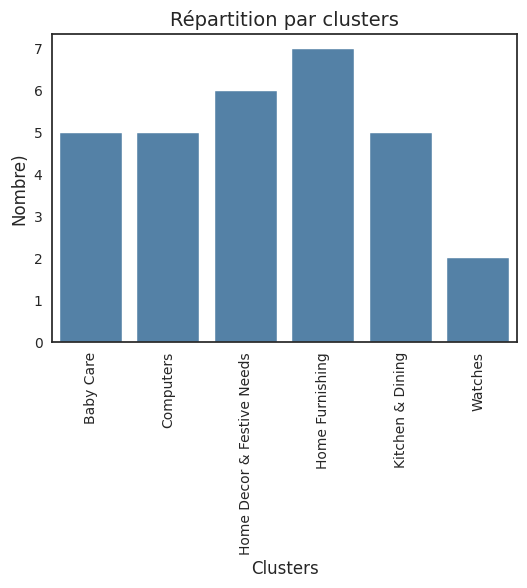

In [37]:
# Labels
labels = df_result['prediction_label']

# Répartition des clusters
affiche_repartition_clusters(labels)

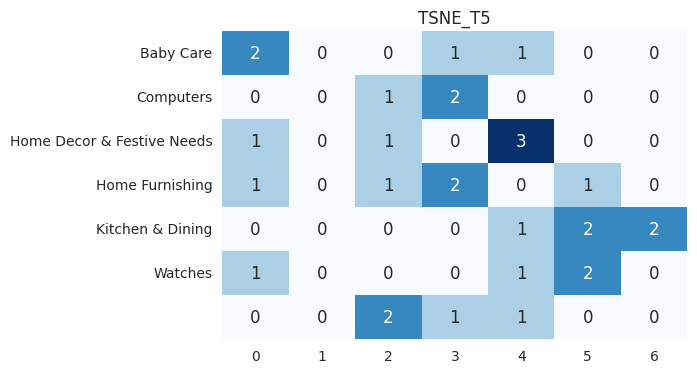

'Précision: 26.67%'

                            precision    recall  f1-score   support

                 Baby Care       0.40      0.50      0.44         4
  Beauty and Personal Care       0.00      0.00      0.00         3
                 Computers       0.20      0.20      0.20         5
Home Decor & Festive Needs       0.33      0.40      0.36         5
           Home Furnishing       0.14      0.20      0.17         5
          Kitchen & Dining       0.40      0.50      0.44         4
                   Watches       0.00      0.00      0.00         4

                  accuracy                           0.27        30
                 macro avg       0.21      0.26      0.23        30
              weighted avg       0.22      0.27      0.24        30


In [38]:
# Heatmap de matrice de confusion
affiche_qualite_classification(df_result, titre)

In [39]:
# Sauvegarde des résultats
df_accuracy_class =sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.3857', '0.2667', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
2,TSNE_T5,0.3857,0.2667


In [40]:
df_accuracy_class

,Type_données,Accuracy_train,Accuracy_test
0,TSNE_ROBERTA_DESC,0.7375,0.7238
1,TSNE_USE_DESC,0.7607,0.7524
2,TSNE_T5,0.3857,0.2667


In [ ]:
# Interprétation : Visualisation des représentations cachées des tokens
# Interprétation : Visualisation des représentations cachées des tokens
text = list(data_sample.values)
encoded_inputs = tokenizer(text, padding=True, return_tensors="pt", truncation=True)
with torch.no_grad():
    # Générer les représentations cachées des tokens
    outputs = model(**encoded_inputs,decoder_input_ids=decoder_input_ids)

In [ ]:
# Récupérer les représentations cachées des tokens
hidden_states = outputs[0]  # Les représentations cachées sont le premier élément du tuple de sortie


In [ ]:
# Utiliser TSNE pour réduire la dimensionnalité
tsne = TSNE(n_components=2, random_state=42)
# Réduire la dimensionnalité des représentations cachées en prenant la moyenne sur l'axe de la séquence
X_proj_tsne = tsne.fit_transform(hidden_states.mean(dim=1).cpu().numpy())

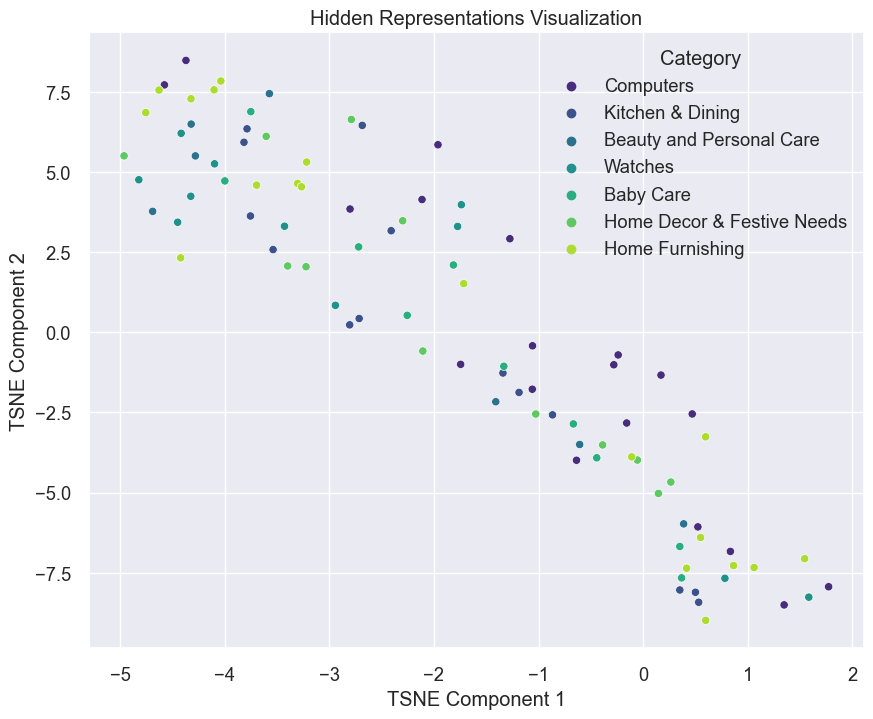

In [ ]:
# Afficher la projection des représentations cachées des tokens
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_proj_tsne[:, 0], y=X_proj_tsne[:, 1], hue=data_cat_sample, palette="viridis")
plt.title("Hidden Representations Visualization")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title="Category")
plt.savefig('inter.png')
plt.show()

## Comparaison entre les différents modeles

In [41]:
# Chargement des données de sauvegarde des résultats des métriques KMeans
df_accuracy_class = pd.read_csv('/content/drive/MyDrive/Test_VT/data_accuracy_classification.csv')
# Supprime varaible Unnamed: 0
df_accuracy_class.drop('Unnamed: 0', axis=1, inplace=True)
df_accuracy_class

,Type_données,Accuracy_train,Accuracy_test
0,TSNE_ROBERTA_DESC,0.7375,0.7238
1,TSNE_USE_DESC,0.7607,0.7524
2,TSNE_T5,0.3857,0.2667


In [42]:
df_comp_nlp = df_accuracy_class.copy()
df_comp_nlp['Accuracy_train'] = \
    df_comp_nlp['Accuracy_train'].astype(float)
df_comp_nlp['Accuracy_test'] = \
    df_comp_nlp['Accuracy_test'].astype(float)

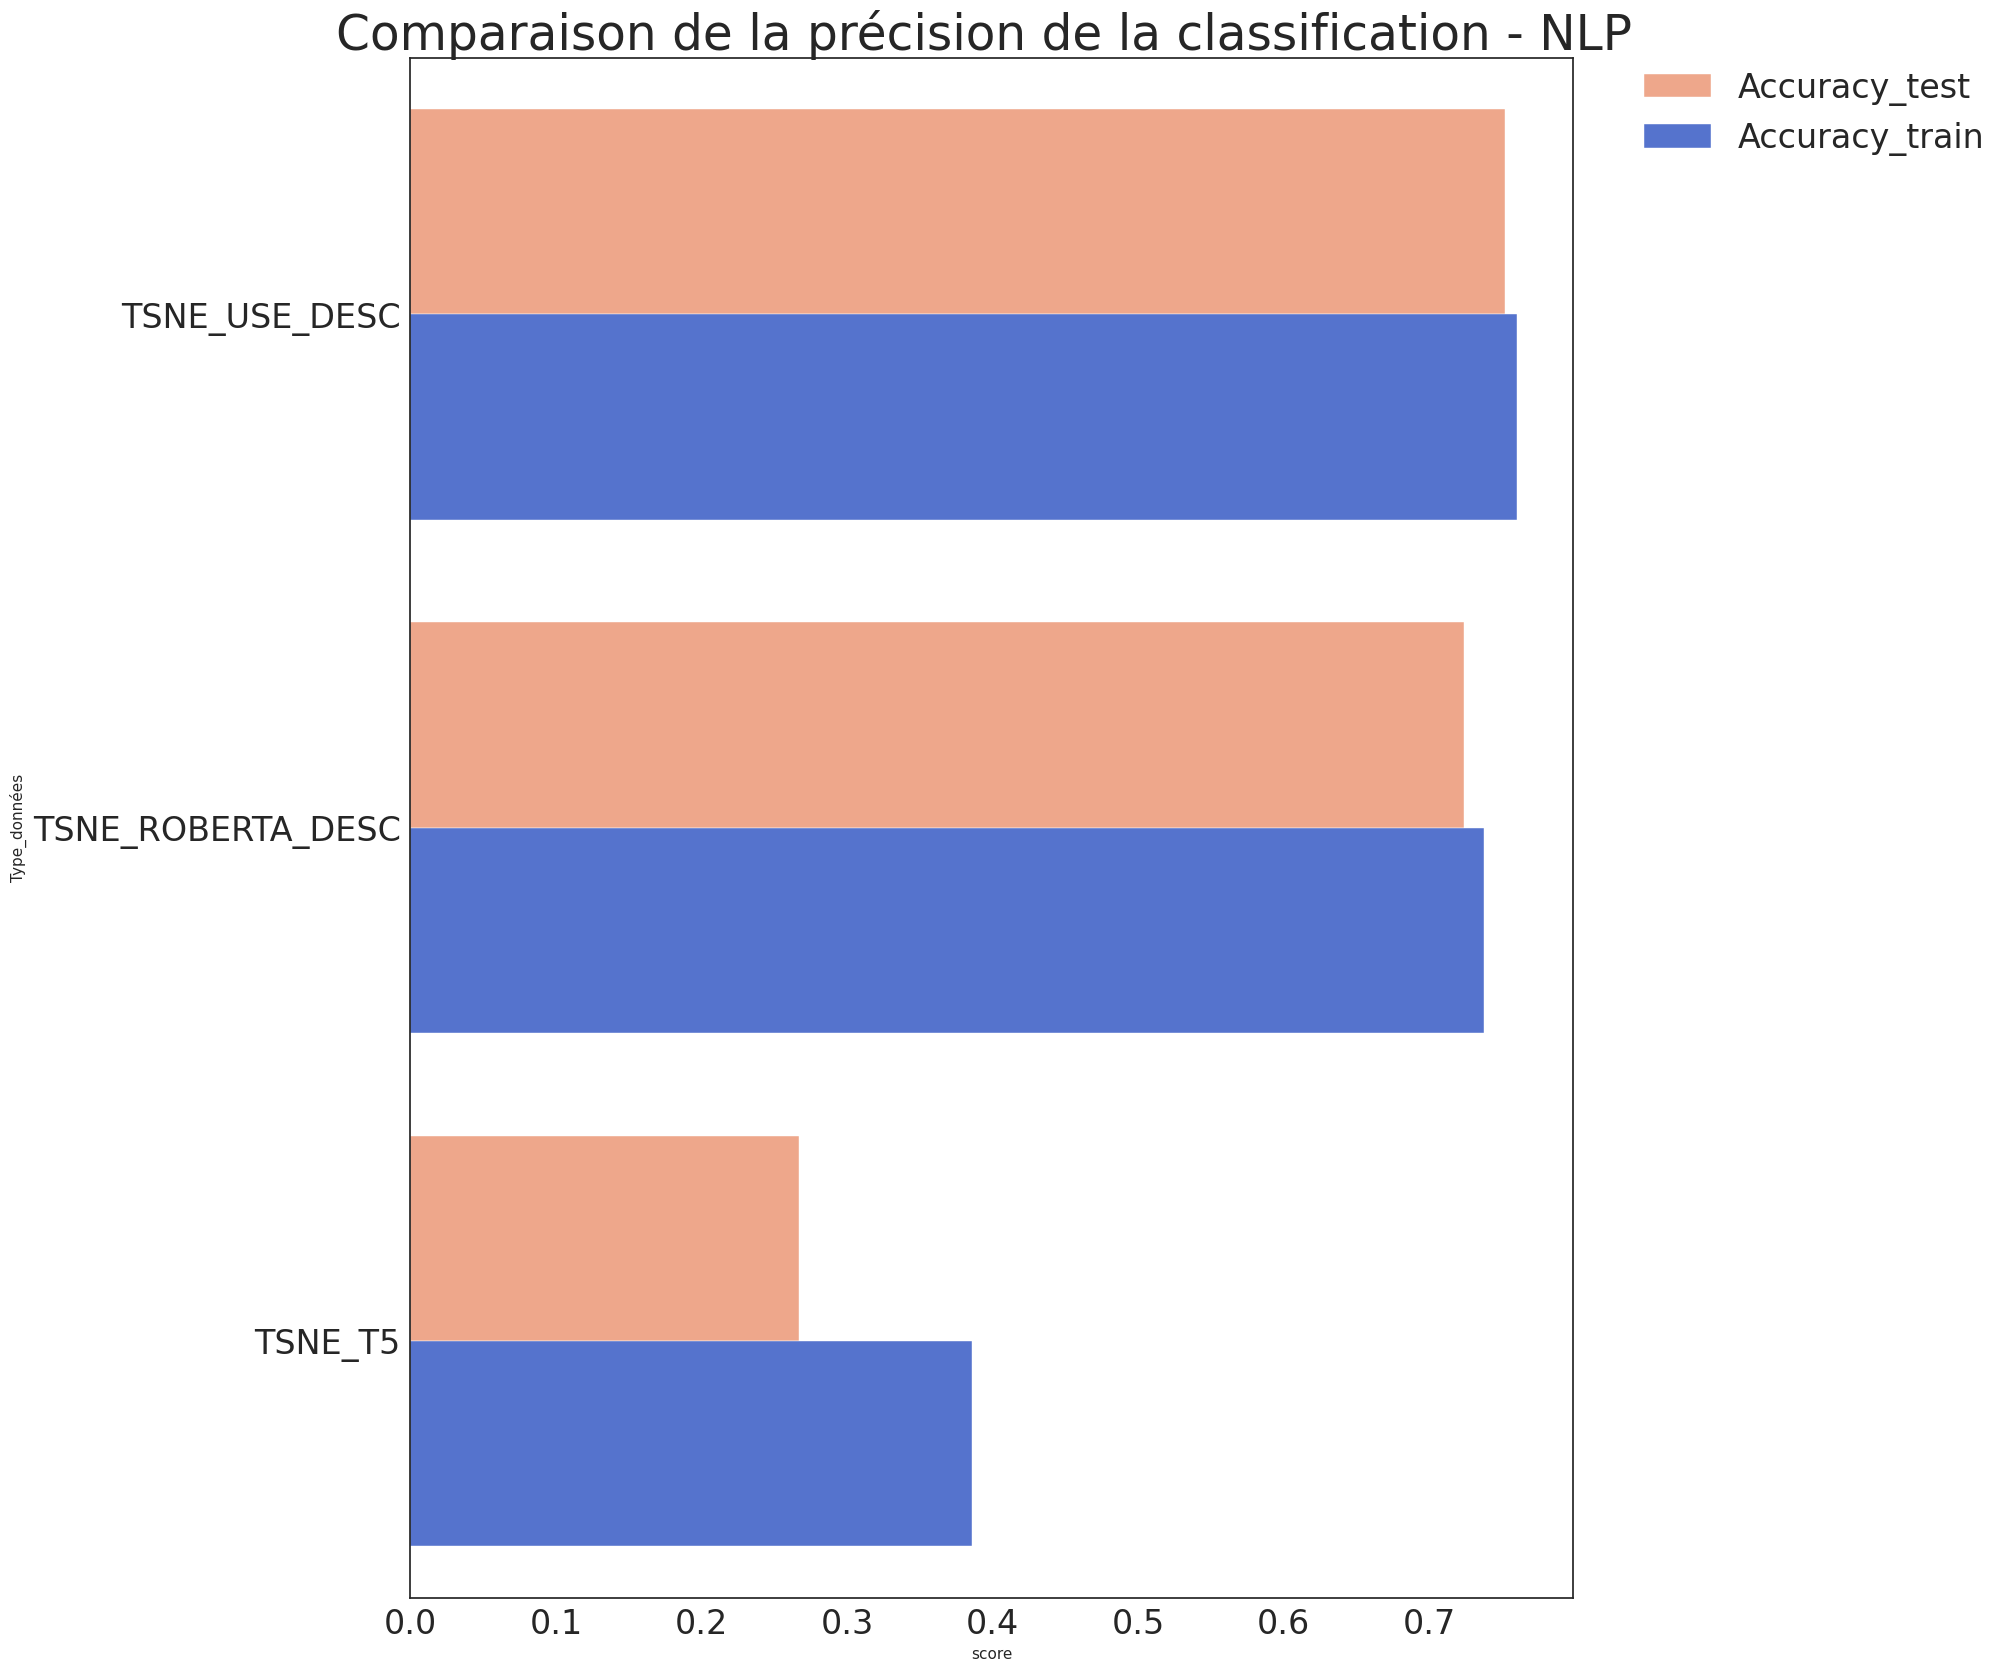

In [43]:
# TEST SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TEST SET
df_comp_nlp_sort = df_comp_nlp.sort_values(by='Accuracy_test',
                                           ascending=False)
comparaison_score_melt = pd.melt(df_comp_nlp_sort,
                                 id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['Accuracy_test',
                                             'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 20))
sns.barplot(y=comparaison_score_melt['Type_données'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP '
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.savefig('comp1.png')
plt.show()

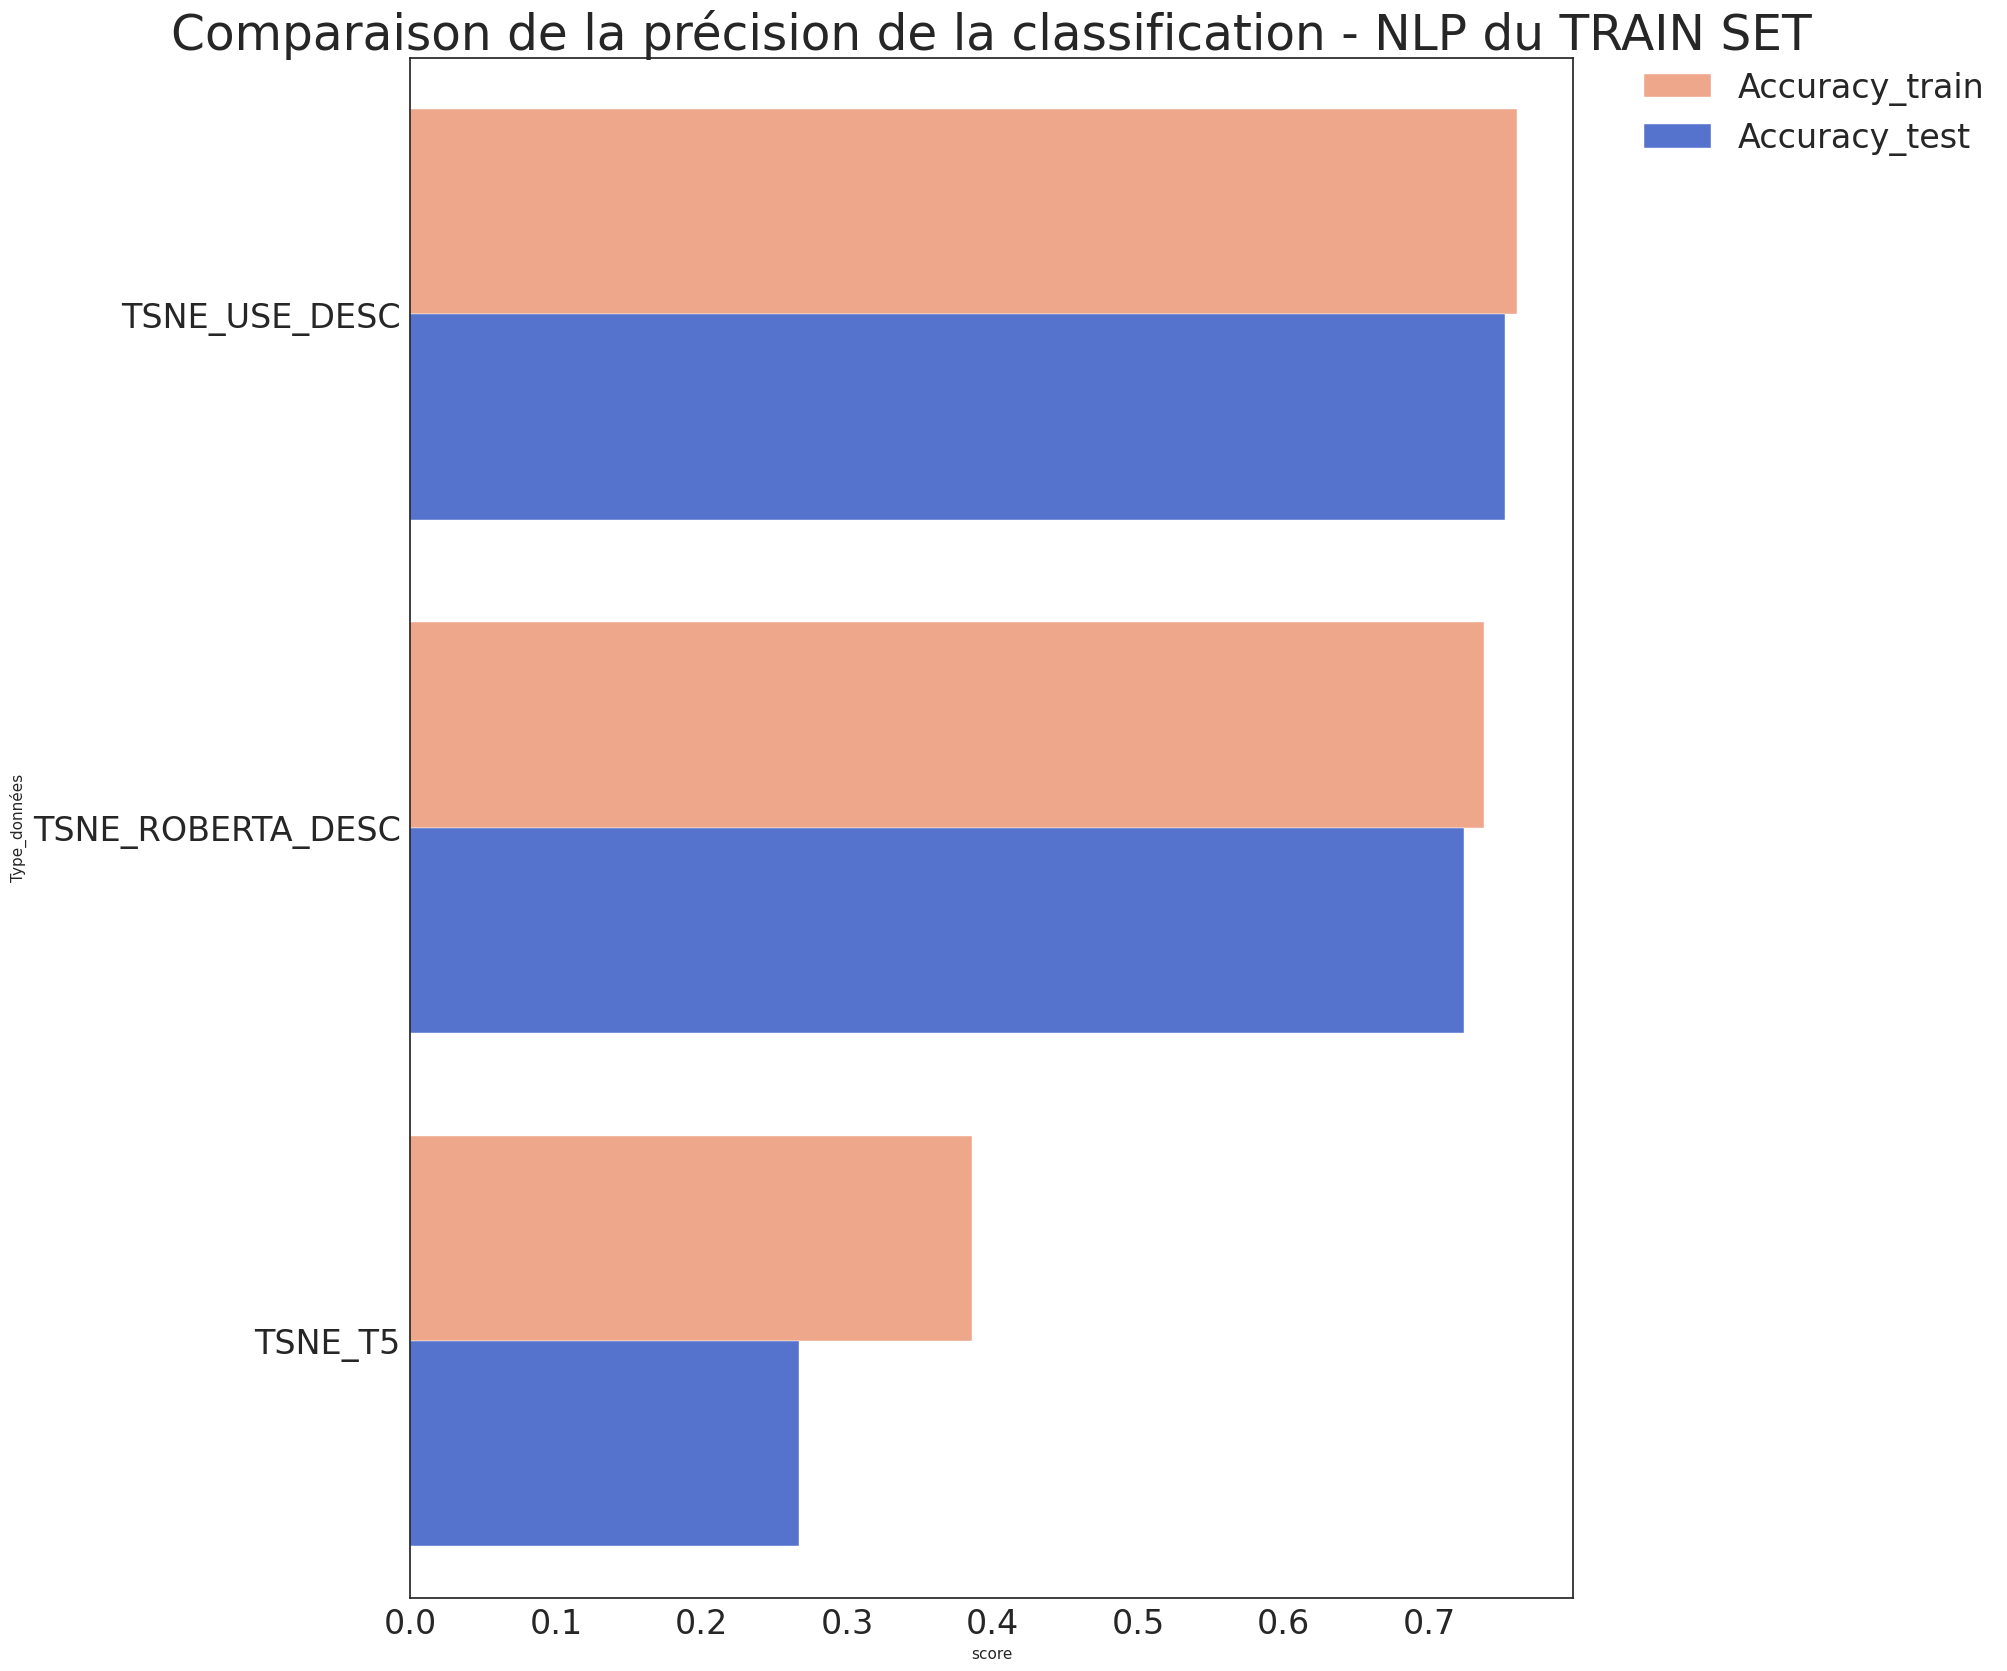

In [44]:
# TRAIN SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TRAIN SET
df_comp_nlp_sort_train = df_comp_nlp.sort_values(by='Accuracy_train',
                                                 ascending=False)
compnlptrain_score_melt = pd.melt(df_comp_nlp_sort_train,
                                  id_vars=['Type_données'],
                                  value_name='score',
                                  value_vars=['Accuracy_train',
                                              'Accuracy_test'])
# Visualisation
plt.figure(figsize=(15, 20))
sns.barplot(y=compnlptrain_score_melt['Type_données'],
            x=compnlptrain_score_melt['score'],
            hue=compnlptrain_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP du TRAIN SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.savefig('comp2.png')
plt.show()

**Bilan**:
Malgrés les bons résultats obtenus avec le modele pré-entrainé utilisé avec T5.
Le language USE avec la version (4) obtient des meilleurs résultats avec le produit  normalisé , lemmatisé et stemmatisé sur le train set et sur le test set.
USE version 4 est l'algorithmes le plus performant pour une classification supervisée.

Pour la suite, nous pouvons envisager l'utilisation d'une classification non-superviséee(K_Means) en évaluant le score ARI.